In [5]:
# import streamlit as st
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import divergence
import scipy
from sklearn.preprocessing import MinMaxScaler
from scipy import signal
from fastdtw import fastdtw
from tslearn.metrics import dtw
plt.style.use('dark_background')

# 正常訊號
sensor_fusion_df = pd.read_csv(r'C:\Users\K18069\Desktop\Molding\K5_1F_空調_WB_MD_RawData_20240131_164932.csv')

# 失效模擬訊號
path = r'C:\Users\K18069\Desktop\Molding\20240312_失效模擬'
dummy_normal_press_df = pd.read_csv(path + '\dummy 正常壓\K1K2_1F_空調_WB_RawData_20240312_162139.csv') # 2024/3/12  04:21:38 PM - 04:23:48 PM
dummy_normal_press_op_df = pd.read_csv(path + '\op正常壓,1shot  transfer time 17.9sec\K1K2_1F_空調_WB_RawData_20240312_143027.csv')  # 2024/3/12  02:30:26 PM - 02:33:13 PM

dummy_air_press_cycle1_df = pd.read_csv(path + '\dummy空壓21_sec\cycle_1\K1K2_1F_空調_WB_RawData_20240312_145917.csv') # 2024/3/12  02:59:17 PM - 03:01:49 PM
dummy_air_press_cycle2_df = pd.read_csv(path + '\dummy空壓21_sec\cycle_2\K1K2_1F_空調_WB_RawData_20240312_150303.csv') # 2024/3/12  03:03:04 PM - 03:05:15 PM

tip_path = r'C:\Users\K18069\Desktop\Molding\20240312_失效模擬\Tip放鬆 空壓dummy transfer time 20.8sec'
tip_releace_cycle1_df = pd.read_csv(tip_path + '\cycle1\K1K2_1F_空調_WB_RawData_20240312_150951.csv') # 2024/3/12  03:09:52 PM - 03:12:01 PM
tip_releace_cycle2_df = pd.read_csv(tip_path + '\cycle 2\K1K2_1F_空調_WB_RawData_20240312_151414.csv') # 2024/3/12  03:14:15 PM - 03:16:25 PM

lock_path =  r'C:\Users\K18069\Desktop\Molding\20240312_失效模擬\下模未鎖緊dummy transfer time 21 sec'
lock_cycle1_df = pd.read_csv(lock_path + '\cycle 1\K1K2_1F_空調_WB_RawData_20240312_152440.csv') # 2024/3/12  03:24:40 PM - 03:26:52 PM
lock_cycle2_df = pd.read_csv(lock_path + '\cycle 2\K1K2_1F_空調_WB_RawData_20240312_152750.csv') # 2024/3/12  03:27:52 PM - 03:30:05 PM

number of peak :  17


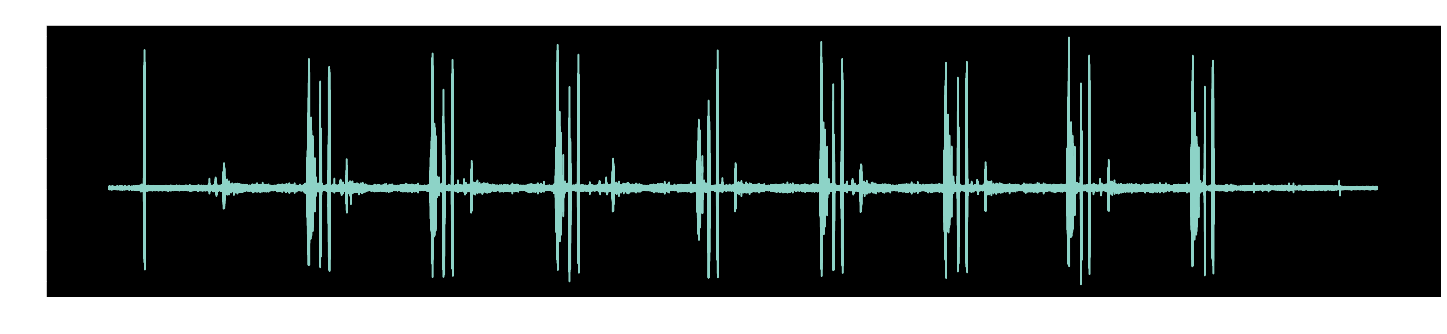

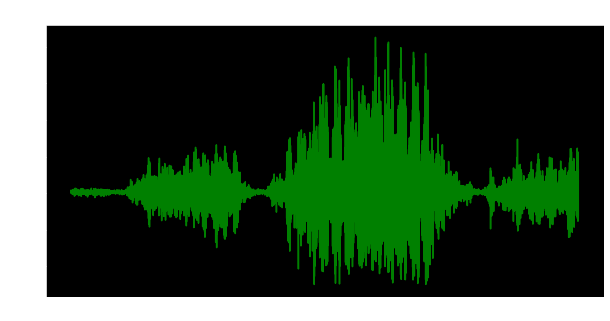

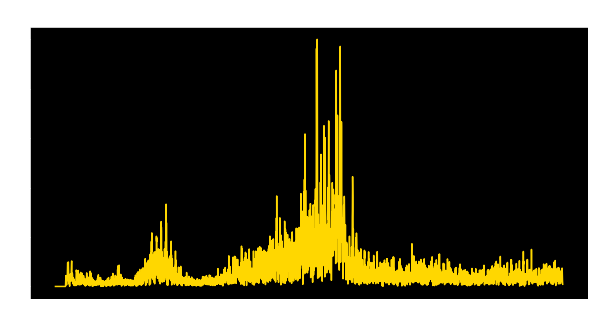

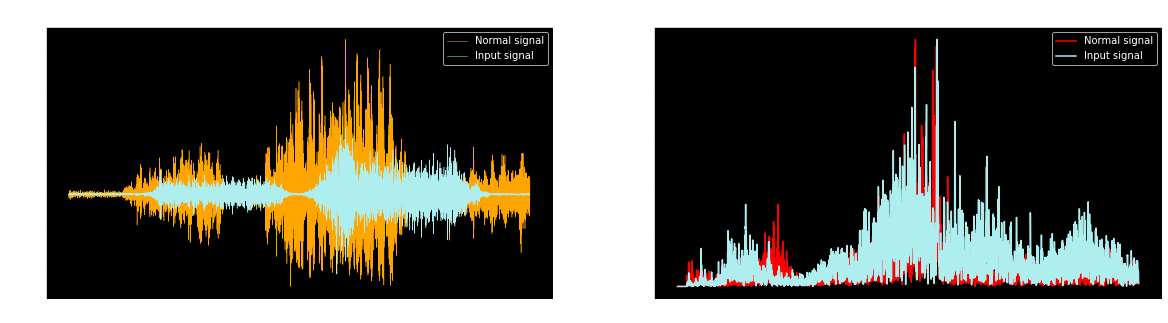

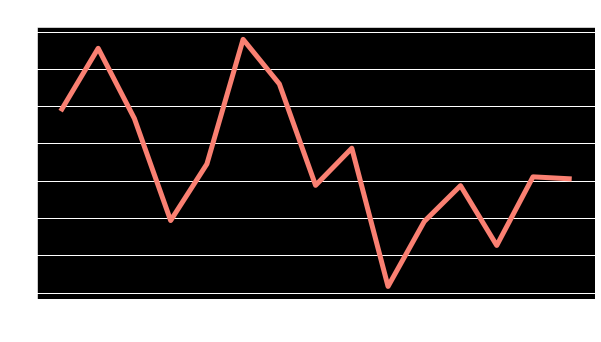

Dynamic similarity 8.109
F-Dynamic similarity 87.63


In [40]:

def Freq_transform(signal_data):
    fs = 2000
    FRAME_LEN = fft_size = len(signal_data)
    xf = np.fft.rfftfreq(FRAME_LEN, 1/fs)
    rfft = np.fft.rfft(signal_data, FRAME_LEN)
    rfft_abs = np.abs(rfft / FRAME_LEN)
    rfft_abs[:FRAME_LEN//100] = 0
    rfft_nor = rfft_abs / np.max(rfft_abs)
    return xf, rfft_nor

def signal_slicing(sig_data, peak_height_rate = 1, peak_distance = 30000, pair_interval = 70000 ):
    peaks, _ = signal.find_peaks(sig_data, height=np.quantile(sig_data, 0.999)*peak_height_rate , distance=peak_distance)
    print('number of peak : ', len(peaks))

    # peak to pair time，取兩個peak的中間段，並只取peak與peak間距離小於70000個點的資料作為分段
    pair_time = []
    peak_list = []
    for i in range(len(peaks)-1):
        if ( peaks[i+1] - peaks[i] ) < pair_interval: 
            pair_time.append( [  peaks[i] -6000 , peaks[i] + 4000] )
            peak_list.append( peaks[i] )

    sliced_signal = []
    for i in range(len(pair_time)):
        segment_start = pair_time[i][0] 
        segment_end = pair_time[i][1]
        sig_piece = sig_data[segment_start:segment_end]
        # sig_piece = MinMaxScaler().fit_transform( sig_piece.reshape(-1,1) ).reshape(1,-1)[0]
        sliced_signal.append(sig_piece )
        
    return pair_time, sliced_signal

def signal_rms(sig_df):
    signal_rms = np.sqrt((np.square(sig_df['x']) + np.square(sig_df['y']) + np.square(sig_df['z'])).astype(float)).to_numpy() # 評估整體的震動幅度
    return signal_rms

def anomaly_signal_slicing(sig_data):
    peaks, _ = signal.find_peaks(sig_data, height=np.quantile(sig_data, 0.9999)  , distance=10000)
    segment_start = peaks[0] - 6000
    segment_end = peaks[0] + 4000
    return sig_data[segment_start:segment_end]

def signal_similarity(normal_signal , input_signal):

    Nor_xf, Nor_rfft_nor = Freq_transform(normal_signal)
    scaled_input_signal = MinMaxScaler().fit_transform( input_signal.reshape(-1,1) ).reshape(1,-1)[0]
    scaled_normal_signal =  MinMaxScaler().fit_transform(  normal_signal.reshape(-1,1) ).reshape(1,-1)[0]
    #========================比較時域震動相似度=======================    
    similarity_rms =  dtw(scaled_normal_signal, scaled_input_signal)
    #========================比較頻率相似度=======================
    xf, input_rfft_nor = Freq_transform(input_signal)
    divergence_ = divergence.divergence_metric()
    similarity_freq  =  1 - divergence_.js_metric( input_rfft_nor  , Nor_rfft_nor ) 
    return np.round(similarity_rms,4),  np.round(similarity_freq,4) * 100

def Dynamic_similarity(normal_signal, input_signal):
    input_xf, input_rfft_nor = Freq_transform(input_signal)
    Nor_xf, Nor_rfft_nor = Freq_transform(normal_signal)

    plt.figure(figsize=(20,5))
    plt.subplot(1,2,1)
    plt.title('Dynamic similarity ', fontsize = 18  )
    plt.plot( normal_signal ,linewidth= 0.5, color = 'orange',label = 'Normal signal')
    plt.plot( input_signal ,linewidth= 0.5 , color = 'paleturquoise',label = 'Input signal')
    plt.legend()

    plt.subplot(1,2,2)
    plt.title('F-Dynamic similarity ', fontsize = 18  )
    plt.plot(Nor_xf, Nor_rfft_nor, color ='red',label = 'Normal signal')
    plt.plot(input_xf, input_rfft_nor, color ='paleturquoise',label = 'Input signal')
    plt.legend()

def Realtime_signal(signal):
    plt.figure(figsize=(25, 5))
    plt.title('Real-time',  fontsize = 16 )
    plt.plot(signal)
    plt.show()

def signal_pattern(signal):
    plt.figure(figsize=(10, 5))
    plt.title('Pattern',  fontsize = 16 )
    plt.plot(signal, color = 'g')
    plt.show()

def Dynamic_Frequrncy(signal):
    xf, rfft_nor = Freq_transform(signal)
    plt.figure(figsize=(10, 5))
    plt.title('Dynamic Frequrncy',  fontsize = 18 )
    plt.plot(xf, rfft_nor, color = 'gold')

def similarity_trend(similarity_list):
    plt.figure(figsize=(10, 5))
    plt.plot(range(len(similarity_list)), similarity_list, 'salmon',linewidth = 5)
    plt.grid(axis='y', linewidth = 1)
    plt.xlabel('Times', fontsize = 16)
    plt.title('similarity trend',  fontsize = 18 )
    plt.show()

# 計算rms
normal_sig = signal_rms(sensor_fusion_df)
anormal_sig = signal_rms(dummy_air_press_cycle1_df)

# 訊號切片
pair_time, sliced_nor_signal = signal_slicing(normal_sig)
sliced_anor_signal = anomaly_signal_slicing(anormal_sig)

Realtime_signal(normal_sig)
signal_pattern(sliced_nor_signal[0])

Dynamic_Frequrncy(sliced_nor_signal[-1])
Dynamic_similarity(sliced_nor_signal[-1],sliced_anor_signal)
# rms_sim, freq_sim = signal_similarity(normal_signal = sliced_nor_signal[-1] , input_signal = sliced_anor_signal )

failure_mode = [dummy_normal_press_df,dummy_normal_press_op_df,dummy_air_press_cycle1_df,dummy_air_press_cycle2_df,tip_releace_cycle1_df,tip_releace_cycle2_df,lock_cycle1_df,lock_cycle2_df]
failure_sig = []

for i in failure_mode:
    anormal_sig = signal_rms(i)
    failure_sig.append( anomaly_signal_slicing(anormal_sig) )

sigsss  = sliced_nor_signal[:7] 
sigsss.extend(failure_sig)

similarity_list = []

for i in sigsss:
    rms_sim, freq_sim = signal_similarity(normal_signal = sliced_nor_signal[-1] , input_signal = i )
    similarity_list.append(freq_sim)

similarity_trend(similarity_list)

print(f'Dynamic similarity {rms_sim}')
print(f'F-Dynamic similarity {freq_sim}')


In [30]:
sigsss

[[array([8158.4955721 , 8169.78420768, 8080.5426798 , ..., 7803.46570442,
         6740.3840395 , 9265.56231429]),
  array([8079.71862134, 8126.77506764, 8120.28503194, ..., 7856.29798315,
         8948.28592525, 6800.13316046]),
  array([8229.77478428, 8162.20815711, 8048.3149168 , ..., 8664.21127397,
         7217.53004843, 6892.76279876]),
  array([8083.59431194, 8064.01692707, 8064.96013629, ..., 6813.68842845,
         7560.71266482, 7685.95999209]),
  array([8012.65368027, 8093.52661082, 8120.99833764, ..., 8762.07058862,
         8761.02465469, 8052.27924255]),
  array([8068.73187062, 8050.59662385, 7966.879251  , ..., 8444.70159331,
         7963.91511758, 7761.76700243]),
  array([8051.25536795, 8092.66118159, 8087.57843857, ..., 7862.57979292,
         8365.82171696, 9109.51140292])],
 [array([8090.67253076, 8075.35020912, 8084.27826092, ..., 8124.95083062,
         8119.65054667, 8128.32516574]),
  array([8012.84256678, 8026.84832297, 8058.50172178, ..., 8315.28941168,
     